# Post-Processing Example 2 - Extracting virtual boreholes from Meshes

This post-processing example shows how to extract vertical and deviated boreholes from PyVista meshes. This means getting the XYZ position where a well intersects with the respective mesh. 

## Licensing

Computational Geosciences and Reservoir Engineering, RWTH Aachen University, Authors: Alexander Juestel. For more information contact: alexander.juestel(at)rwth-aachen.de


This work is licensed under a Creative Commons Attribution 4.0 International License (http://creativecommons.org/licenses/by/4.0/)

## Import GemGIS

If you have installed ``GemGIS`` via pip or conda, you can import ``GemGIS`` like any other package. If you have downloaded the repository, append the path to the directory where the ``GemGIS`` repository is stored and then import ``GemGIS``. 

In [27]:
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg

## Importing Libraries

In [36]:
import numpy as np
import pyvista as pv
import pandas as pd

## Loading and Plotting Meshes

The meshes and colors of the meshes were exported from example 5 and will now be used for this example.



In [2]:
mesh1 = pv.read('../data/postproc2_boreholes/mesh1.vtk')
mesh1

PolyData (0x1be7687dc40)
  N Cells:	12799
  N Points:	6765
  X Bounds:	4.250e+02, 3.922e+03
  Y Bounds:	1.355e+01, 2.615e+03
  Z Bounds:	2.374e+02, 7.180e+02
  N Arrays:	1

In [3]:
mesh2 = pv.read('../data/postproc2_boreholes/mesh2.vtk')
mesh2

PolyData (0x1be7687dfa0)
  N Cells:	29559
  N Points:	15359
  X Bounds:	4.587e+01, 3.922e+03
  Y Bounds:	1.355e+01, 2.696e+03
  Z Bounds:	-4.334e+01, 7.420e+02
  N Arrays:	1

In [10]:
colors = f = open('../data/postproc2_boreholes/colors.txt', "r")
colors = colors.read().split("\n")[:2]
colors 

['#9f0052', '#015482']

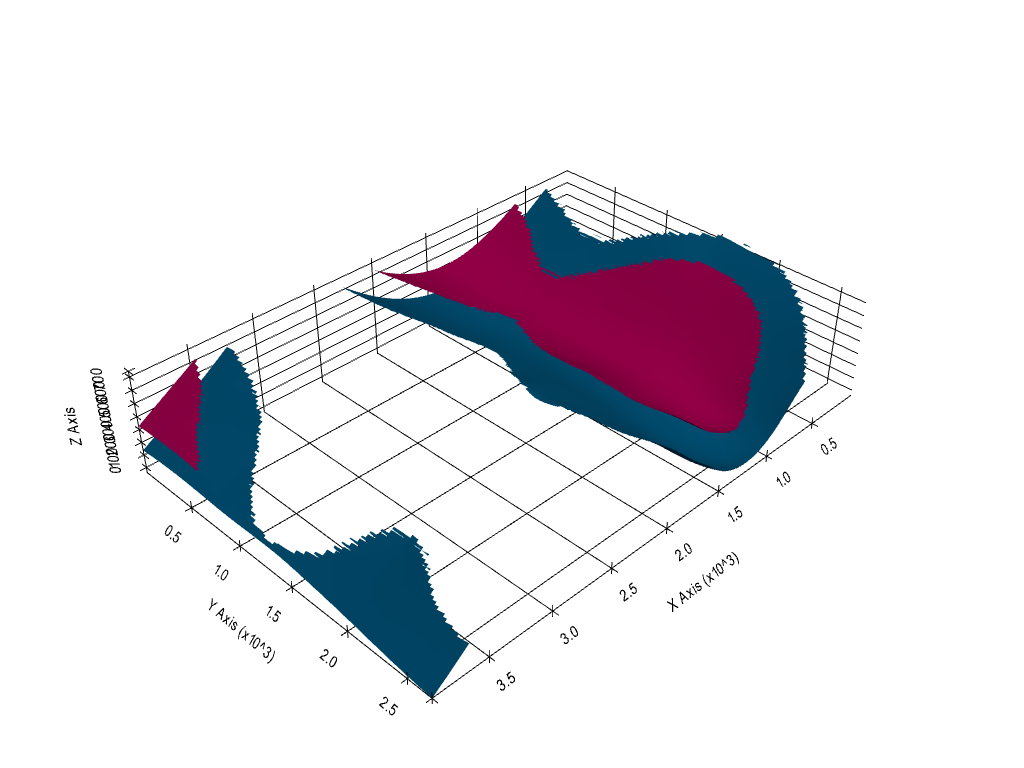

In [17]:
p = pv.Plotter(notebook=True)

p.add_mesh(mesh1, color=colors[0])
p.add_mesh(mesh2, color=colors[1])

p.show_grid(color= 'black')
p.set_background('white')
p.show()

## Extracting intersections between vertical boreholes and meshes

Firstly, a PolyData set is created and visualized. The first attempt shows a straight vertical well. We define the X coordinate to be 1000 m and the Y coordinate to be 1500 m. The well starts at a altitude and is drilled to an altitude of -100 m.

In [45]:
well = pv.Line((1000,1500, 800), (1000,1500, -100))
well_tube = well.tube(radius=20)
well_tube

PolyData (0x1be13b16760)
  N Cells:	22
  N Points:	80
  X Bounds:	9.800e+02, 1.020e+03
  Y Bounds:	1.480e+03, 1.520e+03
  Z Bounds:	-1.000e+02, 8.000e+02
  N Arrays:	3

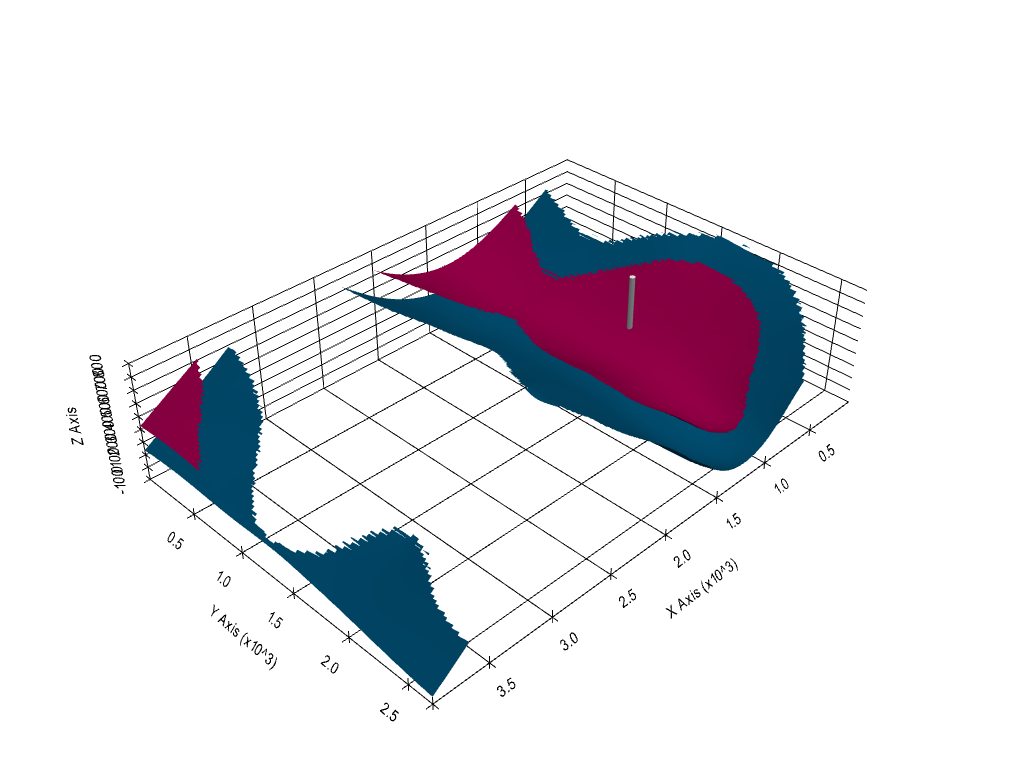

In [46]:
p = pv.Plotter(notebook=True)

p.add_mesh(mesh1, color=colors[0])
p.add_mesh(mesh2, color=colors[1])
p.add_mesh(well_tube, color='white')
p.show_grid(color= 'black')
p.set_background('white')
p.show()

In [48]:
well_tops = gg.utils.create_virtual_profile(names_surfaces=['A', 'B'],
                                            surfaces=[mesh1, mesh2],
                                            borehole_top=well.points[0],
                                            borehole_bottom=well.points[1])

well_tops_df = pd.DataFrame.from_dict(well_tops, orient='index', columns=['Altitude [m]'])
well_tops_df['MD [m]'] = well_tops_df['Altitude [m]']-well.points[0][2]
well_tops_df

,Altitude [m],MD [m]
A,406,-394.00
B,228,-572.00


## Extracting intersections between deviated boreholes and meshes

The second well represents a deviated well that intersects the meshes multiple times

In [79]:
points = np.array(([2500,1500, 800],
                   [2500,1500, 400],
                   [1000, 1500, 400],
                   [0, 1500, 400],
                  ))

# From https://docs.pyvista.org/examples/00-load/create-spline.html
def lines_from_points(points):
    """Given an array of points, make a line set"""
    poly = pv.PolyData()
    poly.points = points
    cells = np.full((len(points) - 1, 3), 2, dtype=np.int_)
    cells[:, 1] = np.arange(0, len(points) - 1, dtype=np.int_)
    cells[:, 2] = np.arange(1, len(points), dtype=np.int_)
    poly.lines = cells
    return poly


well = lines_from_points(points)

well_tube = well.tube(radius=20)
well_tube

PolyData (0x1be14f91460)
  N Cells:	66
  N Points:	240
  X Bounds:	0.000e+00, 2.520e+03
  Y Bounds:	1.480e+03, 1.520e+03
  Z Bounds:	3.800e+02, 8.000e+02
  N Arrays:	1

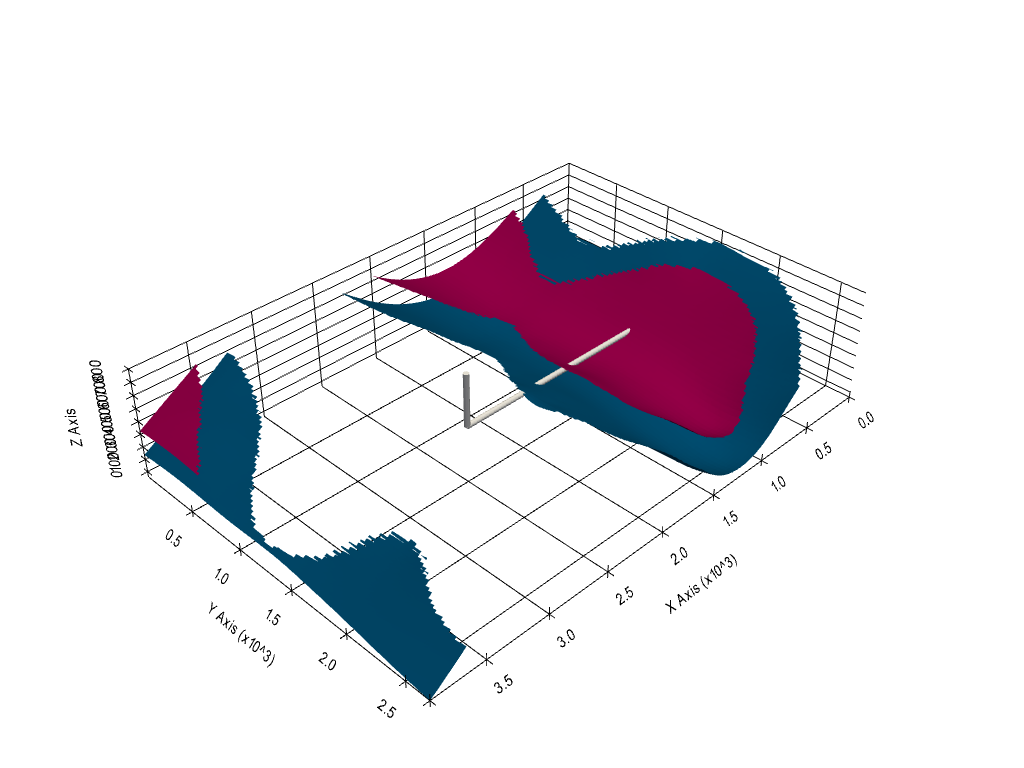

In [80]:
p = pv.Plotter(notebook=True)

p.add_mesh(mesh1, color=colors[0])
p.add_mesh(mesh2, color=colors[1])
p.add_mesh(well_tube, color='white')
p.show_grid(color= 'black')
p.set_background('white')
p.show()

In [69]:
well_tube.points[0]

pyvista_ndarray([2500, 1480,  800])

In [122]:
from typing import Union

def create_virtual_profile(names_surfaces: list,
                           surfaces: list,
                           borehole_top: Union[np.ndarray, list],
                           borehole_bottom: Union[np.ndarray, list],
                           first_point: bool = False):
    """ Function to filter and sort the resulting well tops
    Parameters:
    ___________
        names_surfaces: list
            List of the names of the calculated GemPy surfaces
        surfaces: list
            List of calculated GemPy surfaces
        borehole_top:
            Coordinates of the top of the well
        borehole_bottom:
            Coordinates of the bottom of the well
        first_point: bool
            Returns intersection of first point only
    """

    # Extracting well tops
    well_tops = gg.utils.ray_trace_multiple_surfaces(surfaces=surfaces,
                                            borehole_top=borehole_top,
                                            borehole_bottom=borehole_bottom)

    # Creating dict from names and well tops
    well_dict = dict(zip(names_surfaces, well_tops))

    # Removing empty entries
    for key in well_dict.copy():
        if not well_dict[key][0].any():
            well_dict.pop(key)

    # Splitting layers if they have been encountered more than once
    for key in well_dict.copy():
        if len(well_dict[key][0]) > 1:
            for i in range(1, len(well_dict[key][0])):
                well_dict[key + '_%s' % str(i + 1)] = (well_dict[key][0][i].reshape(1, 3), well_dict[key][1][i])

    # Extracting only Z value from dict
    for key in well_dict.keys():
        well_dict[key] = well_dict[key][0][0]

    # Sorting well dict
#     well_dict = dict(sorted(well_dict.items(), key=lambda item: item[1], reverse=True))

    return well_dict

In [142]:
well_tops = [create_virtual_profile(names_surfaces=['A', 'B'],
                                            surfaces=[mesh1, mesh2],
                                            borehole_top=well.points[i],
                                            borehole_bottom=well.points[i+1]) for i in range(len(well.points)-1)]



well_tops_df = pd.concat([pd.DataFrame.from_dict(df, orient='index', columns=[ 'X', 'Y', 'Z']) for df in well_tops])

well_tops_df

,X,Y,Z
A,1539.12,1500.00,400.00
B,1855.84,1500.00,400.00
A_2,1014.59,1500.00,400.00
B,686.17,1500.00,400.00
